Display time-between-failures, failure intensity and reliability graphs

## Imports

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from scipy.stats import weibull_min
from reliability.Repairable_systems import reliability_growth
from reliability.Datasets import system_growth

## Load Data

In [6]:
# Load data
df = pd.read_csv('failure-dataset-a5.csv')

# Data preparation
df['Time_Between_Failures'] = df['T'].diff().dropna()
df['Failure_Intensity'] = df['FC'] / df['T']

## Analysis

### Cumulative Failures Over Time


Weibull Parameters:
Shape (β): 1.760
Scale (η): 17.851


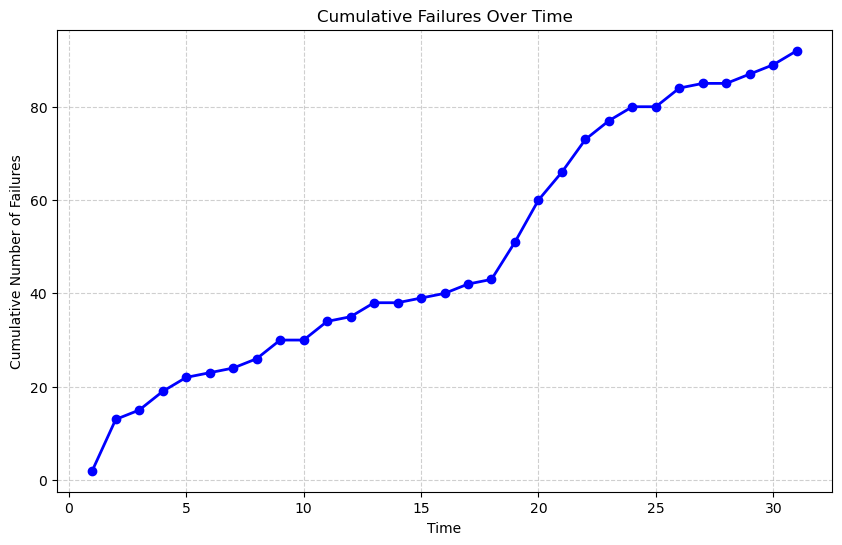

In [13]:
shape, loc, scale = weibull_min.fit(df['T'].values, floc=0)
print("\nWeibull Parameters:")
print(f"Shape (β): {shape:.3f}")
print(f"Scale (η): {scale:.3f}")

plt.figure(figsize=(10, 6))
cumulative_failures = df['FC'].cumsum()
plt.plot(df['T'], cumulative_failures, 'b-o', linewidth=2, markersize=6)
plt.xlabel('Time')
plt.ylabel('Cumulative Number of Failures')
plt.title('Cumulative Failures Over Time')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Duane reliability growth model parameters:
Alpha: 0.42531
A: 0.57338
Demonstrated MTBF (cumulative): 26.86511
Demonstrated MTBF (instantaneous): 46.74719
Demonstrated failure intensity (cumulative): 0.03722
Demonstrated failure intensity (instantaneous): 0.02139
Time to reach target MTBF: 1154.77862



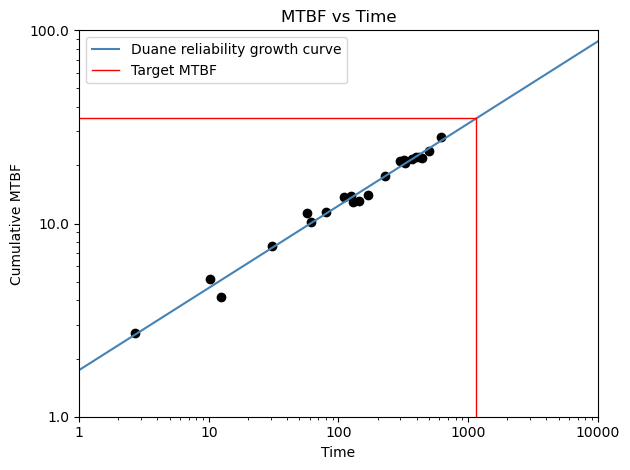

AttributeError: 'reliability_growth' object has no attribute 'alpha'

In [7]:
# Fit Duane model
d = reliability_growth(times=system_growth().failures, model="Duane", target_MTBF=35, log_scale=True)
plt.show()
alpha, beta = d.alpha, d.beta

# Manual plot to match your style
plt.figure(figsize=(10, 6))
plt.plot(df['T'], df['FC'].cumsum(), 'bo-', label='Observed Failures')
t = np.linspace(0, df['T'].max(), 100)
plt.plot(t, alpha * t**beta, 'r--', label=f'Duane Fit: α={alpha:.3f}, β={beta:.3f}')
plt.xlabel('Time')
plt.ylabel('Cumulative Failures')
plt.title('Duane Model: Cumulative Failures vs. Power-Law Fit')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### Survival Analysis

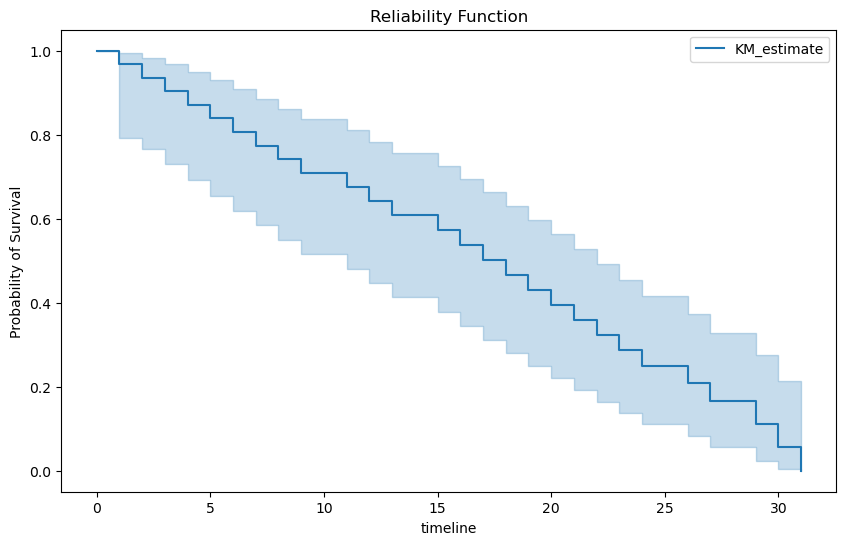

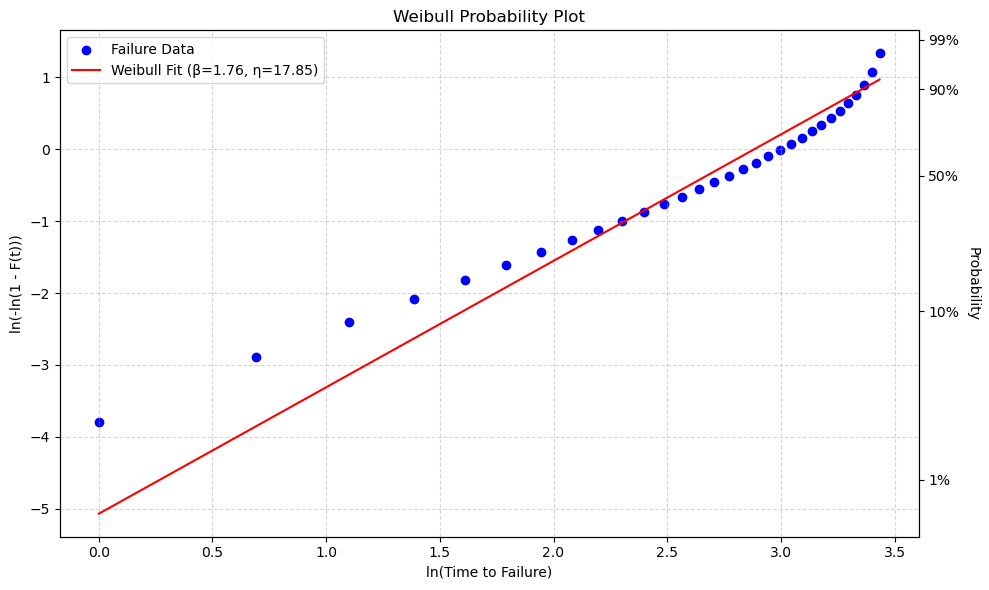

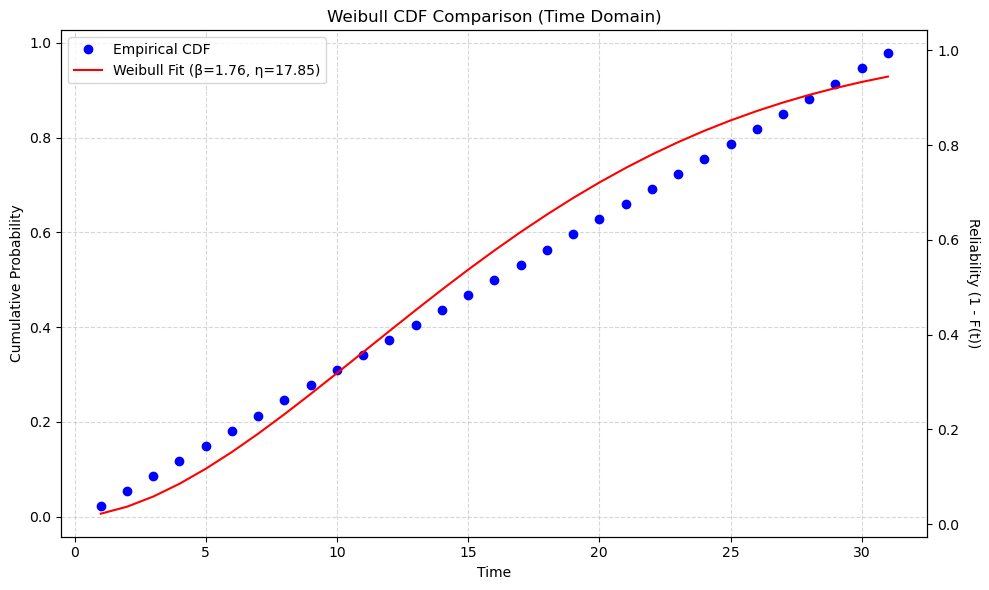

In [11]:
# Kaplan-Meier Survival Analysis
kmf = KaplanMeierFitter()
kmf.fit(durations=df['T'], event_observed=df['FC'])
plt.figure(figsize=(10, 6))
kmf.plot_survival_function()
plt.title('Reliability Function')
plt.ylabel('Probability of Survival')
plt.show()

# Enhanced Weibull Probability Plot
plt.figure(figsize=(10, 6))

# Calculate plotting positions
sorted_data = np.sort(df['T'].values)
n = len(sorted_data)
prob = (np.arange(1, n+1) - 0.3) / (n + 0.4)  # Bernard's approximation
weibull_transformed = np.log(-np.log(1 - prob))

# Plot data points
plt.scatter(np.log(sorted_data), weibull_transformed, 
           label='Failure Data', color='blue')

# Plot fitted line
x = np.linspace(sorted_data.min(), sorted_data.max(), 100)
y = shape * (np.log(x) - np.log(scale))
plt.plot(np.log(x), y, 'r-', 
        label=f'Weibull Fit (β={shape:.2f}, η={scale:.2f})')

# Formatting
plt.xlabel('ln(Time to Failure)')
plt.ylabel('ln(-ln(1 - F(t)))')
plt.title('Weibull Probability Plot')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend()

# Add probability scale on right side
ax = plt.gca()
ax2 = ax.twinx()
ax2.set_ylabel('Probability', rotation=270, labelpad=15)
ax2.set_yticks(np.log(-np.log(1 - np.array([0.01, 0.1, 0.5, 0.9, 0.99]))))
ax2.set_yticklabels(['1%', '10%', '50%', '90%', '99%'])
ax2.set_ylim(ax.get_ylim())

plt.tight_layout()
plt.show()


# Create a new figure for the time-domain visualization
plt.figure(figsize=(10, 6))

# Empirical CDF (using same plotting positions as before)
sorted_times = np.sort(df['T'].values)
empirical_cdf = (np.arange(1, n+1) - 0.3) / (n + 0.4)  # Bernard's approximation

# Weibull CDF from fitted parameters
weibull_cdf = weibull_min.cdf(sorted_times, shape, loc=0, scale=scale)

# Plot both CDFs
plt.plot(sorted_times, empirical_cdf, 'bo', label='Empirical CDF')
plt.plot(sorted_times, weibull_cdf, 'r-', label=f'Weibull Fit (β={shape:.2f}, η={scale:.2f})')

# Formatting
plt.xlabel('Time')
plt.ylabel('Cumulative Probability')
plt.title('Weibull CDF Comparison (Time Domain)')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend()

# Add secondary axis showing reliability (1 - CDF)
ax = plt.gca()
ax2 = ax.twinx()
ax2.set_ylabel('Reliability (1 - F(t))', rotation=270, labelpad=15)
ylim = ax.get_ylim()
ax2.set_ylim(1 - ylim[1], 1 - ylim[0])  # Invert the CDF axis
ax2.grid(False)  # Avoid double grid

plt.tight_layout()
plt.show()


### Verify Weibull fit with scipy

Weibull parameters - shape: 1.760, scale: 17.851


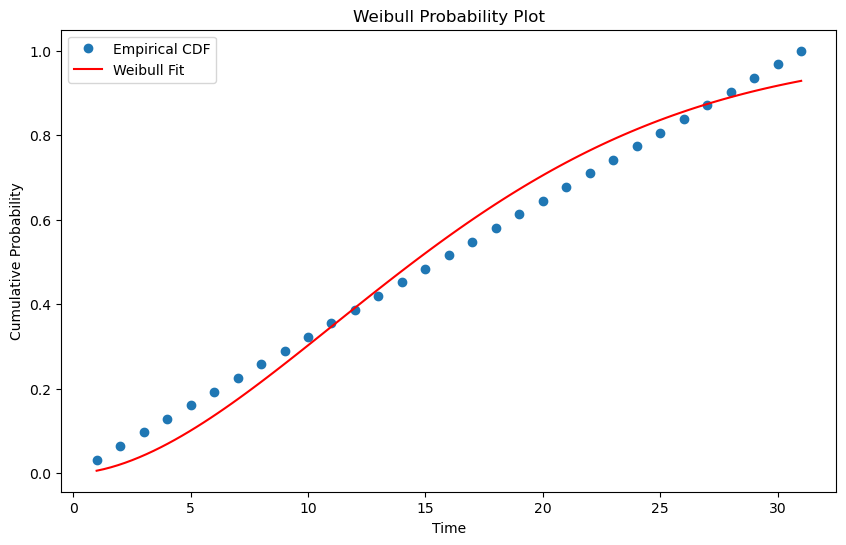

In [12]:
from scipy.stats import weibull_min
import matplotlib.pyplot as plt
import pandas as pd

# Fit Weibull distribution using scipy
shape, loc, scale = weibull_min.fit(df['T'].values, floc=0)
print(f"Weibull parameters - shape: {shape:.3f}, scale: {scale:.3f}")

# Generate probability plot manually
sorted_data = np.sort(df['T'].values)
cdf = np.arange(1, len(sorted_data)+1) / len(sorted_data)
plt.figure(figsize=(10, 6))
plt.plot(sorted_data, cdf, 'o', label='Empirical CDF')
x = np.linspace(sorted_data.min(), sorted_data.max(), 100)
plt.plot(x, weibull_min.cdf(x, shape, loc=0, scale=scale), 
         'r-', label='Weibull Fit')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Cumulative Probability')
plt.title('Weibull Probability Plot')
plt.show()



### Failure Intensity Over Time

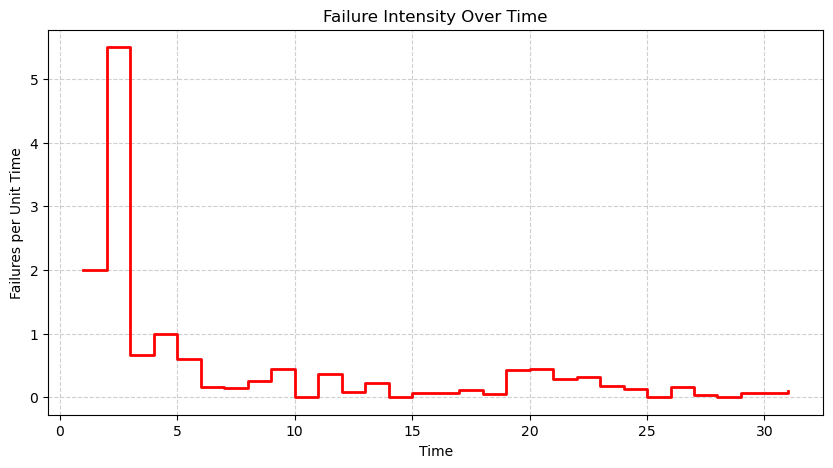

In [14]:
plt.figure(figsize=(10, 5))
plt.step(df['T'], df['Failure_Intensity'], where='post', color='red', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Failures per Unit Time')
plt.title('Failure Intensity Over Time')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### Weibull Hazard Rate

- β>1: Rising curve = "Aging" system (wear-out)
- β=1: Flat line = Constant risk (random failures)
- β<1: Declining curve = "Infant mortality"

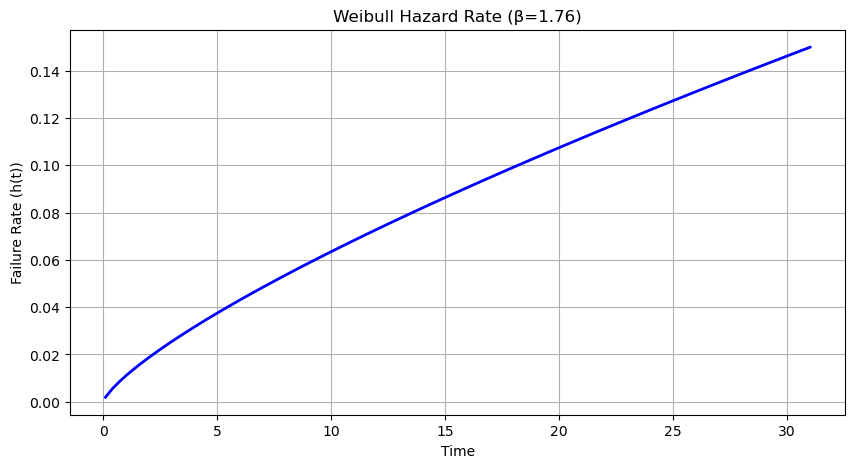

In [16]:
t = np.linspace(0.1, df['T'].max(), 100)  # Avoid t=0
hazard_rate = (shape/scale) * (t/scale)**(shape-1)  # Weibull hazard function

plt.figure(figsize=(10, 5))
plt.plot(t, hazard_rate, 'b-', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Failure Rate (h(t))')
plt.title(f'Weibull Hazard Rate (β={shape:.2f})')
plt.grid(True)
plt.show()

### Reliability Function

Shows the probability of survival over time.

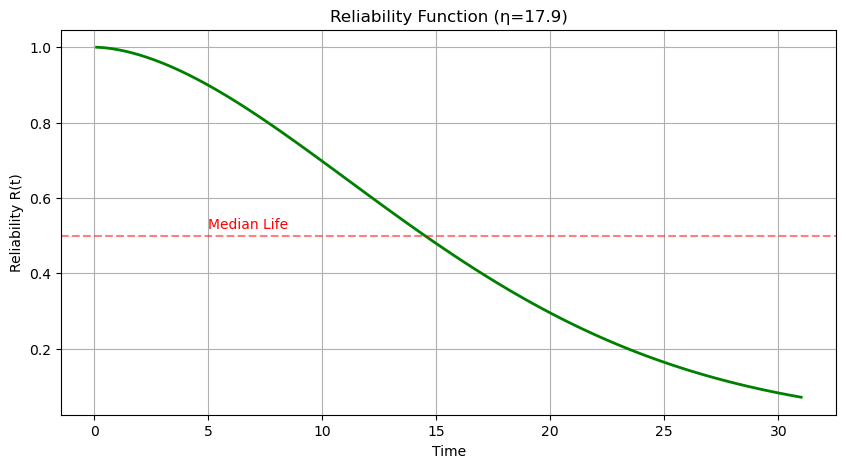

In [17]:
reliability = np.exp(-(t/scale)**shape)  # Weibull survival function

plt.figure(figsize=(10, 5))
plt.plot(t, reliability, 'g-', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Reliability R(t)')
plt.title(f'Reliability Function (η={scale:.1f})')
plt.grid(True)
plt.axhline(0.5, color='r', linestyle='--', alpha=0.5)
plt.text(5, 0.52, 'Median Life', color='r')
plt.show()

### Probability Density Function

- Peak indicates the most likely failure time.
- Right-skewed curves are common in reliability data.

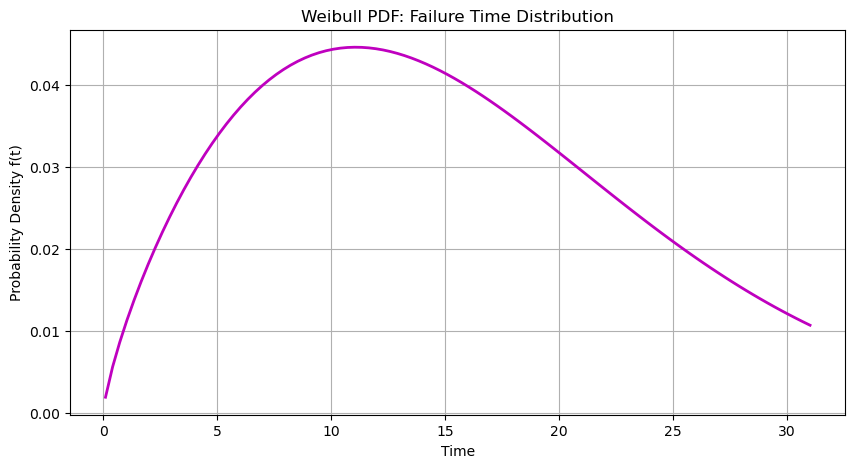

In [18]:
pdf = (shape/scale) * (t/scale)**(shape-1) * np.exp(-(t/scale)**shape)

plt.figure(figsize=(10, 5))
plt.plot(t, pdf, 'm-', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Probability Density f(t)')
plt.title('Weibull PDF: Failure Time Distribution')
plt.grid(True)
plt.show()

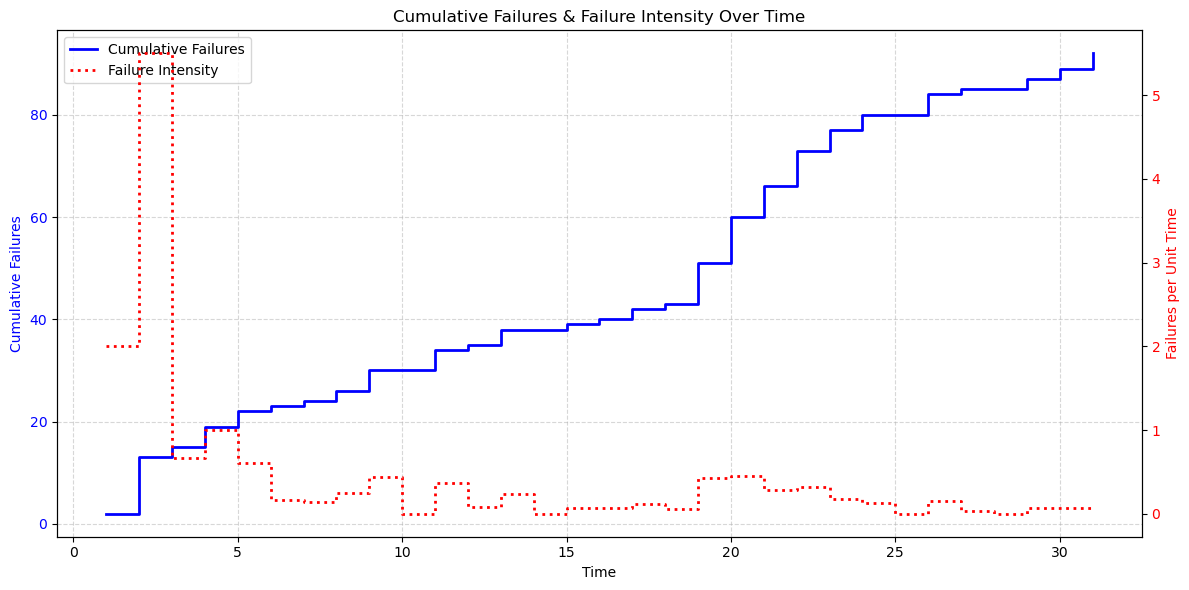

In [19]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Cumulative Failures (Left Y-axis)
ax1.step(df['T'], df['FC'].cumsum(), 
         where='post', color='blue', linewidth=2, label='Cumulative Failures')
ax1.set_xlabel('Time')
ax1.set_ylabel('Cumulative Failures', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, linestyle='--', alpha=0.5)

# Create secondary axis for Failure Intensity
ax2 = ax1.twinx()
ax2.step(df['T'], df['Failure_Intensity'], 
         where='post', color='red', linewidth=2, linestyle=':', label='Failure Intensity')
ax2.set_ylabel('Failures per Unit Time', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add titles and legends
plt.title('Cumulative Failures & Failure Intensity Over Time')
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()